<a href="https://colab.research.google.com/github/LeeHuiJong/Deep_learning/blob/main/ch04_07_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.07 Variational AutoEncoder

* 날짜:
* 이름:

## 학습내용
    - Variational AutoEncoder를 이해하고 구현한다.


In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys

## VAE 기본 구현
---

![](https://user-images.githubusercontent.com/24144491/50323466-18d03700-051d-11e9-82ed-afb1b6e2666a.png)

### **| Encoder, Decoder 구현**

In [ ]:
class Sampling(layers.Layer): # 상속

  def call(self, inputs):
    z_mu, z_sigma = inputs
    z_epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mu))
    z = ( tf.exp(z_epsilon*0.5) * z_sigma ) + z_mu
    return z

class BuildModel():
  def __init__(self, x_shape=(28,28,1), z_dims=100):
    self.x_shape = x_shape
    self.z_dims = z_dims

  def build_encoder(self):
    x = layers.Input(shape = self.x_shape )
    z = layers.Conv2D(32, 3, strides=2, padding='same', activation='leaky_relu')(x)
    z = layers.Conv2D(32, 3, strides=2, padding='same', activation='leaky_relu')(z)
    self.z_conv_shape = z.shape[1:] # (7, 7, 32)
 
    z = layers.Flatten()(z)
    z_mu = layers.Dense(z_dims, activation='relu')(z)
    z_sigma = layers.Dense(z_dims, activation='relu')(z)

    z = Sampling()([z_mu, z_sigma])
    encoder = models.Model(x, [z_mu, z_sigma, z], name='Encoder')
    return encoder

  def build_decoder(self):
    z = layers.Input(shape = self.z_dims)
    y = layers.Dense(256, activation='relu')(z)
    dim = self.z_conv_shape[0]*self.z_conv_shape[1]*self.z_conv_shape[2]
    y = layers.Dense(dim, activation = 'relu')(y)
    y = layers.Reshape(self.z_conv_shape)(y)
    y = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='leaky_relu')(y)
    y = layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')(y)

    decoder = models.Model(z, y, name='Decoder')
    return decoder

In [ ]:
x_shape = (28,28,1)
z_dims = 10
builder = BuildModel(x_shape, z_dims)
encoder = builder.build_encoder()
decoder = builder.build_decoder()
encoder.summary()
decoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 32)     9248        ['conv2d_4[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 1568)         0           ['conv2d_5[0][0]']               
                                                                                            

### **| 손실함수 정의**

![](https://user-images.githubusercontent.com/24144491/50323472-1a016400-051d-11e9-86b7-d8bf6a1a880f.png)

In [ ]:
'''loss.py'''
def get_rec_loss(imgs, recs):
  rec_loss = tf.keras.losses.binary_crossentropy(imgs, recs)
  red_loss = tf.reduce_mean(rec_loss)
  return rec_loss

def get_kl_loss(z_mu, z_sigma):
  kl_loss = tf.square(z_mu) + ( tf.exp(z_sigma) - z_sigma - 1)
  kl_loss = 0.5 * tf.reduce_mean(kl_loss)
  return kl_loss

### **| VAE 구현**

In [ ]:
class VAE():
  def __init__(self, encoder, decoder, x_shape):
    self.encoder = encoder
    self.decoder = decoder
    self.x_shape = x_shape

  def compile(self, optimizer = tf.keras.optimizers.Adam() ):
    img = layers.Input(shape = x_shape)
    z_mu, z_sigma, z  = self.encoder(img)
    rec = self.decoder(z)

    self.vae = models.Model(img, rec, name='VAE')
    self.optimizer = optimizer

  @tf.function
  def train_step(self, imgs):
    # imgs.shape = (16, 28, 28, 1)
    with tf.GradientTape() as tape:
      
      # propagation
      z_mu, z_sigma, z = self.encoder(imgs)
      recs = self.decoder(z)

      # loss 계산 - (rec loss / kl loss)
      rec_loss = get_rec_loss(imgs, recs) # 원본 이미지와 재구성한 이미지가 최대한 비슷해지면 좋겠다
      kl_loss = get_kl_loss(z_mu, z_sigma) # z가 다양하면서, 정보량 유사
      loss = rec_loss + kl_loss

    # gradient 계산
    weights = self.vae.trainable_variables
    gradients = tape.gradient(loss, weights)

    # weight 업데이트
    self.optimizer.apply_gradients(zip(gradients,weights))

    return loss, rec_loss, kl_loss

  def fit(self, x_data, epochs = 1, batch_size=16):

    train_ds = tf.data.Dataset.from_tensor_slices(x_data).batch(batch_size)
    self.batch_size=batch_size
    history = {'loss':[0 for i in range(epochs)], 
               'rec_loss':[0 for i in range(epochs)], 
               'kl_loss':[0 for i in range(epochs)] }

    for epoch in range(1, epochs+1):
      self.epoch=epoch     
      for imgs in train_ds:
        loss, rec_loss, kl_loss = self.train_step(imgs)
        loss, rec_loss, kl_loss = loss.numpy(), rec_loss.numpy(), kl_loss.numpy()
        history['loss'][epoch-1]+=loss
        history['rec_loss'][epoch-1]+=rec_loss
        history['kl_loss'][epoch-1]+=kl_loss
        
      print( f"* [ {epoch} / {epochs}]  loss: {history['loss'][epoch-1]} rec_loss: {history['rec_loss'][epoch-1]} kl_loss: {history['kl_loss'][epoch-1]}" )
      self.plot_sample_imgs(imgs)

  def plot_sample_imgs(self, imgs, n=10):
    plt.figure(figsize=(n,2))
    rec_imgs = self.vae.predict(imgs[:n])
    for i, (img, rec_img) in enumerate(zip(imgs, rec_imgs)):
        plt.subplot(2,n,i+1)
        plt.imshow(np.squeeze(img), cmap='gray_r')
        plt.axis('off')
        plt.subplot(2,n,n+i+1)
        plt.imshow(np.squeeze(rec_img), cmap='gray_r')
        plt.axis('off')
    plt.show()

### **| 학습**

In [ ]:
def get_mnist():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_train = x_train.astype(np.float32) / 255
  x_train = x_train.reshape(-1, 28, 28, 1)
  x_test = x_test.astype(np.float32) / 255
  x_test = x_test.reshape(-1, 28, 28, 1)

  return x_train, x_test

In [ ]:
x_train, x_test = get_mnist()
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
x_shape = (28,28,1)
z_dims = 100
builder = BuildModel(x_shape, z_dims)
encoder = builder.build_encoder()
decoder = builder.build_decoder()
vae = VAE(encoder, decoder, x_shape)
vae.compile()
vae.vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        [(None, 100),             323368    
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         438369    
                                                                 
Total params: 761,737
Trainable params: 761,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vae.fit(x_train, 5)

### **| 결과 확인**

## 새소리 클러스터링
---

In [3]:
! unzip /content/drive-download-20220902T001337Z-001.zip -d wav_data

Archive:  /content/drive-download-20220902T001337Z-001.zip
  inflating: wav_data/w58y67_20200428_103140_478.wav  
  inflating: wav_data/w58y67_20200428_115428_195.wav  
  inflating: wav_data/w58y67_20200428_114115_693.wav  
  inflating: wav_data/w58y67_20200428_100956_441.wav  
  inflating: wav_data/w58y67_20200428_115458_281.wav  
  inflating: wav_data/w58y67_20200428_115758_389.wav  
  inflating: wav_data/w58y67_20200428_115328_692.wav  
  inflating: wav_data/w58y67_20200428_104922_885.wav  
  inflating: wav_data/w58y67_20200428_115441_635.wav  
  inflating: wav_data/w58y67_20200428_115748_736.wav  
  inflating: wav_data/w58y67_20200428_115512_215.wav  
  inflating: wav_data/w58y67_20200428_115755_699.wav  
  inflating: wav_data/w58y67_20200428_115802_306.wav  
  inflating: wav_data/w58y67_20200428_112708_610.wav  
  inflating: wav_data/w58y67_20200428_103224_961.wav  
  inflating: wav_data/w58y67_20200428_115326_814.wav  
  inflating: wav_data/w58y67_20200428_103142_843.wav  
  infl

In [4]:
! git clone http://github.com/yebiny/Songbird-clusturing.git

Cloning into 'Songbird-clusturing'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 332 (delta 32), reused 65 (delta 18), pack-reused 227
Receiving objects: 100% (332/332), 49.60 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [8]:
sys.path.append('/content/Songbird-clusturing/data_process')
from syllable_generator import *
from draw_tools import *

In [9]:
gen = SyllableGenerator('/content/wav_data')

In [10]:
gen.wav_list

['/content/wav_data/w58y67_20200428_100953_641.wav',
 '/content/wav_data/w58y67_20200428_100956_441.wav',
 '/content/wav_data/w58y67_20200428_103140_478.wav',
 '/content/wav_data/w58y67_20200428_103142_843.wav',
 '/content/wav_data/w58y67_20200428_103144_435.wav',
 '/content/wav_data/w58y67_20200428_103224_961.wav',
 '/content/wav_data/w58y67_20200428_104922_885.wav',
 '/content/wav_data/w58y67_20200428_104927_155.wav',
 '/content/wav_data/w58y67_20200428_104942_424.wav',
 '/content/wav_data/w58y67_20200428_112708_610.wav',
 '/content/wav_data/w58y67_20200428_112731_559.wav',
 '/content/wav_data/w58y67_20200428_114105_931.wav',
 '/content/wav_data/w58y67_20200428_114108_571.wav',
 '/content/wav_data/w58y67_20200428_114115_693.wav',
 '/content/wav_data/w58y67_20200428_114129_585.wav',
 '/content/wav_data/w58y67_20200428_115323_681.wav',
 '/content/wav_data/w58y67_20200428_115326_814.wav',
 '/content/wav_data/w58y67_20200428_115328_692.wav',
 '/content/wav_data/w58y67_20200428_115343_164

/content/wav_data/w58y67_20200428_112731_559.wav


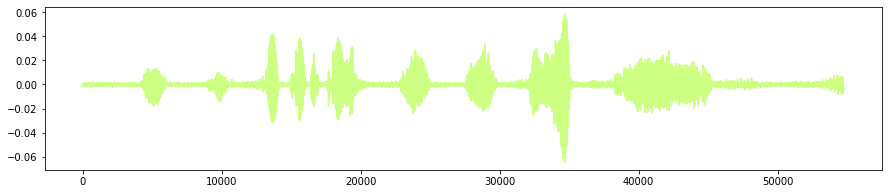

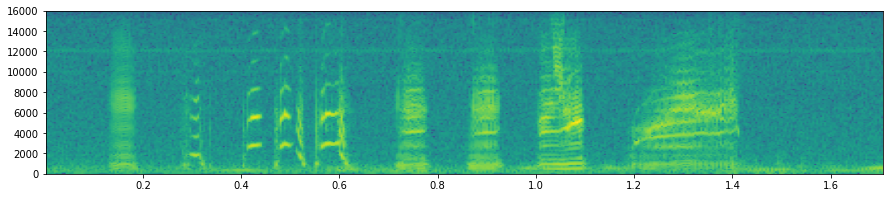

In [11]:
idx = 10
wav = gen.wav_list[idx]
print(wav)

draw_wav(wav)
draw_spectrogram(wav)

In [12]:
syllables = gen.get_syllable_list(gen.wav_list)

* Finish Idx 0 wav file :  w58y67_20200428_100953_641
* Finish Idx 10 wav file :  w58y67_20200428_112731_559
* Finish Idx 20 wav file :  w58y67_20200428_115428_195
* Finish Idx 30 wav file :  w58y67_20200428_115802_306
* Finish Idx 40 wav file :  w58y67_20200428_115916_607
* Finish Idx 50 wav file :  w58y67_20200428_120203_663


In [16]:
print(syllables.shape)
print('   idx start point   length')
print(syllables[:3])

wav_idx = syllables[:, 0]
start_point = syllables[:,1]
length = syllables[:,2]

(765, 3)
   idx start point   length
[[    0  3891  2001]
 [    0  8697  1882]
 [    0 13002  1608]]


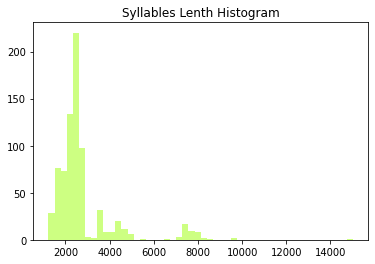

In [19]:
hist_syllable_lenth(length)

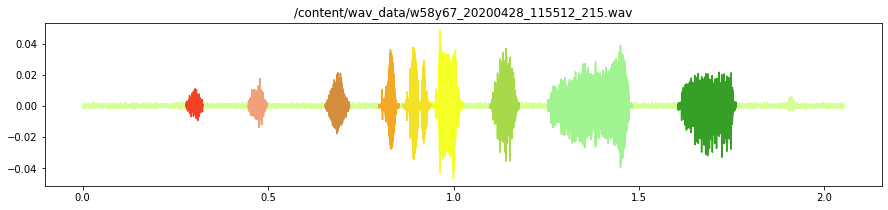

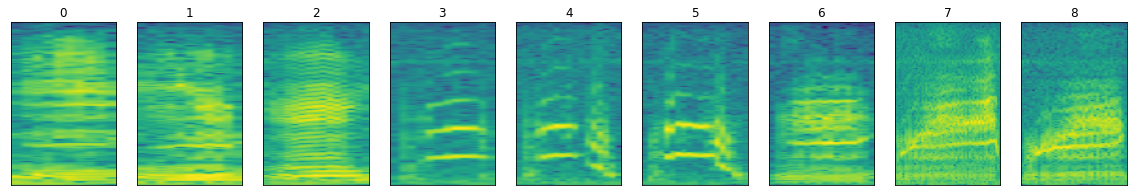

In [21]:
idx = 26
draw_split_wav(gen.wav_list, syllables, idx)
draw_split_spectrogram(gen.wav_list, syllables, idx)

In [23]:
from data_process import *

dp = DataProcess(gen.wav_list, syllables)

ys, imgs = dp.get_dataset()
ys.shape, imgs.shape

* Start process...  total syllables: 765
0
100
200
300
400
500
600
700


((765,), (765, 128, 64))

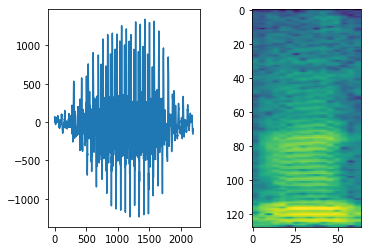

In [24]:
plt.subplot(121); plt.plot(ys[idx])
plt.subplot(122); plt.imshow(imgs[idx])

(765, 128, 64, 1)

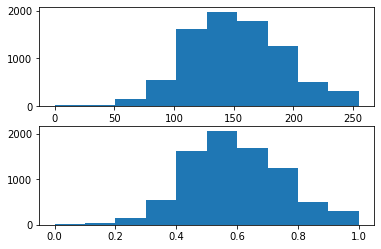

In [27]:
x_data = imgs/255.
x_data = np.expand_dims(x_data, 3)
plt.subplot(211); plt.hist(imgs[0].flatten())
plt.subplot(212); plt.hist(x_data[0].flatten())
x_data.shape

In [29]:
np.save('wav_data/pre/x_train', x_data)
np.save('wav_data/pre/x_test', x_data)

In [28]:
sys.path.append('/content/Songbird-clusturing/2-Train')
from trainVAE_ver1 import *

In [30]:
z_dims = 2
data_path = 'wav_data/'
save_path = 'result'
vae = TrainVAE(z_dims, data_path, save_path)
vae.vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 64, 1)]      0         
                                                                 
 encoder (Functional)        [(None, 2),               357284    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 128, 64, 1)        357761    
                                                                 
Total params: 715,045
Trainable params: 715,045
Non-trainable params: 0
_________________________________________________________________


In [31]:
vae.train(1000,4)

* 0 * loss: 5395.098633,  best_loss: 5395.098633, l_rate: 0.001000, lr_count: 0
* 1 * loss: 5293.265137,  best_loss: 5293.265137, l_rate: 0.001000, lr_count: 0
* 2 * loss: 5273.119141,  best_loss: 5273.119141, l_rate: 0.001000, lr_count: 0
* 3 * loss: 5264.005371,  best_loss: 5264.005371, l_rate: 0.001000, lr_count: 0
* 4 * loss: 5261.198730,  best_loss: 5261.198730, l_rate: 0.001000, lr_count: 0
* 5 * loss: 5255.573730,  best_loss: 5255.573730, l_rate: 0.001000, lr_count: 0
* 6 * loss: 5251.783691,  best_loss: 5251.783691, l_rate: 0.001000, lr_count: 0
* 7 * loss: 5249.152832,  best_loss: 5249.152832, l_rate: 0.001000, lr_count: 0
* 8 * loss: 5250.416504,  best_loss: 5249.152832, l_rate: 0.001000, lr_count: 0
* 9 * loss: 5246.917480,  best_loss: 5246.917480, l_rate: 0.001000, lr_count: 0
* 10 * loss: 5246.335449,  best_loss: 5246.335449, l_rate: 0.001000, lr_count: 0
* 11 * loss: 5240.130859,  best_loss: 5240.130859, l_rate: 0.001000, lr_count: 0
* 12 * loss: 5247.811523,  best_loss: 

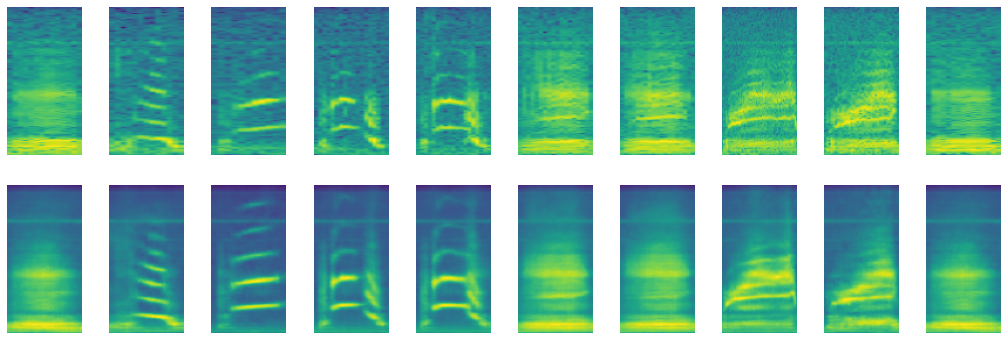

In [34]:
# 복원이 잘 됐는지
recs = vae.vae.predict(x_data)
recs.shape, x_data.shape

plt.figure(figsize = (18,6))
for i in range(10):
  plt.subplot(2,10,i+1); plt.imshow(x_data[i,:,:,0]);plt.axis('off')
  plt.subplot(2,10, i+1+10); plt.imshow(recs[i,:,:,0]);plt.axis('off')

In [37]:
def plot_project(data_2d, c_lenth=1, save=None):

    x = data_2d[:,0]
    y = data_2d[:,1]

    if type(c_lenth)==int:
        fig=plt.figure(figsize=(6,6))
        c = plt.scatter(x, y, marker='.', c='black', alpha=0.4)      
    else:
        fig=plt.figure(figsize=(8,6))
        c = plt.scatter(x, y, c=c_lenth, cmap='jet', marker='.')
        plt.colorbar(c)
    if save!=None:
        plt.savefig(save)
    plt.show()

In [35]:
mu, sigma, z = vae.encoder.predict(x_data)
z.shape

(765, 2)

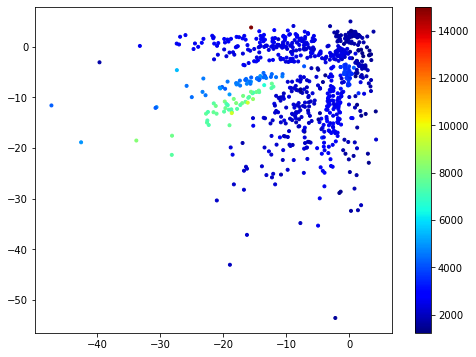

In [39]:
plot_project(z, length)

In [43]:
grid_x = np.linspace(-5, 5, 11)
grid_y = np.linspace(-5, 5, 11)
X, Y = np.meshgrid(grid_x, grid_y)

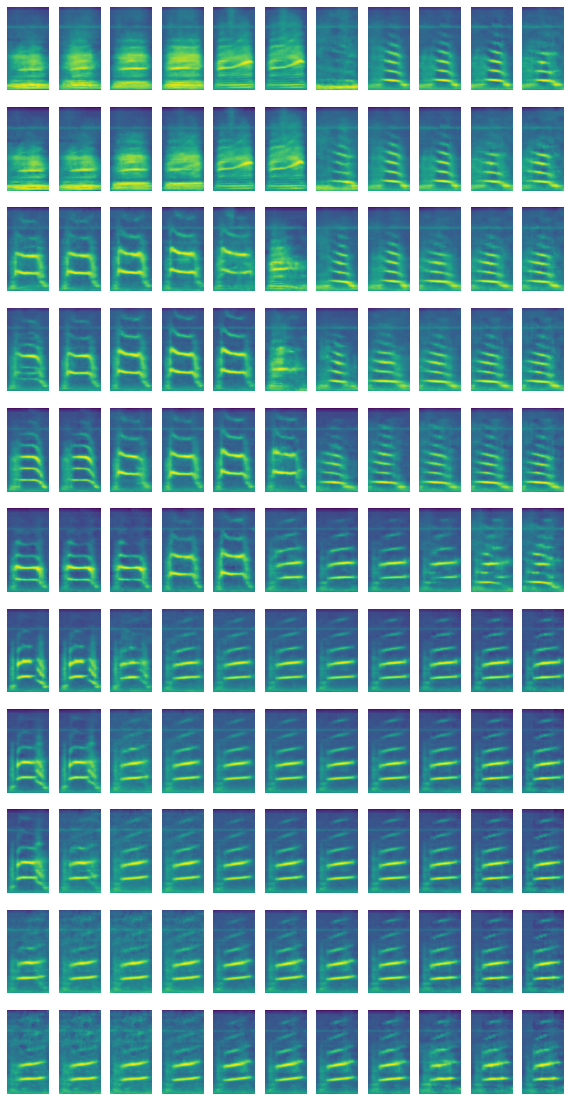

In [45]:
plt.figure(figsize=(10,20))
i=0
for xx, yy in zip(X, Y):
  for x, y in zip(xx, yy):
    z_sample = np.array([[x, y]])
    recs = vae.decoder.predict(z_sample)
    rec = recs[0,:,:,0]
    i+=1
    plt.subplot(11,11,i)
    plt.imshow(rec)
    plt.axis('off')